<a href="https://colab.research.google.com/github/ivoryRabbit/NIMS_PLIM/blob/gh-pages/2_NAIVE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Naive models

- 학습이 따로 필요하지 않고 test set만으로도 예측이 가능한 모델들입니다.
- SES(Simple Exponential Smoothing) 계열 모델들은 계절성 혹은 추세를 고려하여 가중치를 두는 방식을 사용합니다.
- (참고) EDA에서 4.1과 4.5를 덜 수행한채 학습했던 모델이라 약간의 점수차가 있습니다.

## Results

1. Just use the values of the previous year
    - 결과: 24.23303
2. Mean values for each month on the previous year
    - 결과: 24.88944
3. Mean values of each month over the years
    - 결과: 23.56102
4. Simple Exponential Smoothing
    - 결과: 35.38682
5. Holt's Linear Trend Method
    - 결과: 35.41009
6. Holt-Winters Method
    - 결과: 22.70955

In [ ]:
import pandas as pd
import numpy as np
import glob, re, gc, os
np.random.seed(777)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

from sklearn.model_selection import train_test_split

from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing

import warnings
warnings.filterwarnings('ignore')

In [ ]:
train = pd.read_csv('data/train_clean.csv', index_col = 'id')
test = pd.read_csv('data/test.csv', index_col = 'id')
sample_submission = pd.read_csv('data/sample_submission.csv', index_col = 'id')
print(train.shape, test.shape, sample_submission.shape) 

(66170, 125) (10000, 113) (10000, 12)


In [ ]:
X = train.loc[:, '2009-06': '2018-05']
y = train.loc[:, '2018-06':]
X_test = test.loc[:, '2009-06':]

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 10000, random_state = 777)

### 1. Just use the values of the previous year

In [ ]:
def model_1(df):
    result = df.iloc[:, -12:].copy()
    result.columns = sample_submission.columns
    return result

In [ ]:
X_sample, y_sample = X_train.iloc[0], y_train.iloc[0]
y_pred = model_1(X_train).iloc[0]

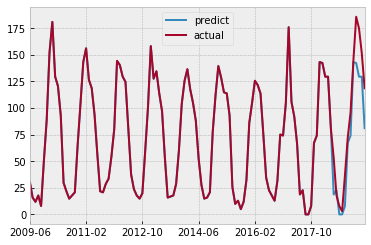

In [ ]:
pd.concat([X_sample, y_pred]).plot()
pd.concat([X_sample, y_sample]).plot()
plt.legend(['predict', 'actual'])
plt.show()

In [ ]:
submission = model_1(X_test)
submission.head()

,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05
id,,,,,,,,,,,,
78587,15.80,16.79,12.84,9.88,14.82,27.66,66.20,83.98,93.86,79.06,53.36,33.60
78588,25.69,15.80,10.86,8.89,9.88,23.71,44.46,82.01,92.88,79.06,55.34,26.68
78589,12.84,10.86,7.90,7.90,10.86,20.75,59.28,81.02,92.88,69.18,38.54,14.82
78590,10.86,8.89,7.90,9.88,12.84,8.89,34.58,64.22,64.22,64.23,49.41,39.53
78591,14.82,13.83,14.82,13.83,15.80,23.71,60.27,83.98,82.01,88.94,57.32,22.73


In [ ]:
submission.to_csv('submissions/submission_NAIVE_1.csv')

### 2. Mean values for each month

In [ ]:
def model_2(df):
    mean = df.iloc[:, -12:].mean(axis = 0).values.reshape(1, -1)
    result = pd.DataFrame(
        data = np.repeat(mean, test.shape[0], axis = 0),
        columns = sample_submission.columns,
        index = sample_submission.index
    )
    return result

In [ ]:
X_sample, y_sample = X_train.iloc[0], y_train.iloc[0]
y_pred = model_2(X_train).iloc[0]

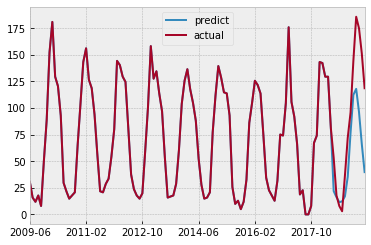

In [ ]:
pd.concat([X_sample, y_pred]).plot()
pd.concat([X_sample, y_sample]).plot()
plt.legend(['predict', 'actual'])
plt.show()

In [ ]:
submission = model_2(X_test)
submission.head()

,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05
id,,,,,,,,,,,,
78587,15.462132,11.865392,8.522864,9.410376,12.777364,24.660091,55.45112,82.680122,87.545635,68.595784,44.560283,25.623164
78588,15.462132,11.865392,8.522864,9.410376,12.777364,24.660091,55.45112,82.680122,87.545635,68.595784,44.560283,25.623164
78589,15.462132,11.865392,8.522864,9.410376,12.777364,24.660091,55.45112,82.680122,87.545635,68.595784,44.560283,25.623164
78590,15.462132,11.865392,8.522864,9.410376,12.777364,24.660091,55.45112,82.680122,87.545635,68.595784,44.560283,25.623164
78591,15.462132,11.865392,8.522864,9.410376,12.777364,24.660091,55.45112,82.680122,87.545635,68.595784,44.560283,25.623164


In [ ]:
submission.to_csv('submissions/submission_NAIVE_2.csv')

### 3. Mean values of each month over the years

In [ ]:
def model_3(df):
    df_month = pd.DataFrame()
    for month in [f'{i+1:02d}' for i in range(12)]:
        temp = np.mean(df.loc[:, df.columns[df.columns.str.contains(f'-{month}')]], axis = 1)
        df_month[f'{month}'] = temp
    result = df_month[[f'{i+1:02d}' for i in list(range(5, 12)) + list(range(5))]]
    result.columns = sample_submission.columns
    return result

In [ ]:
X_sample, y_sample = X_train.iloc[0], y_train.iloc[0]
y_pred = model_3(X_train).iloc[0]

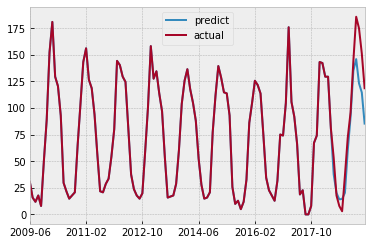

In [ ]:
pd.concat([X_sample, y_pred]).plot()
pd.concat([X_sample, y_sample]).plot()
plt.legend(['predict', 'actual'])
plt.show()

In [ ]:
submission = model_3(X_test)
submission.head()

,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05
id,,,,,,,,,,,,
78587,16.142222,13.286667,12.408889,10.432222,12.630000,24.053333,56.792222,78.324444,82.826667,67.116667,50.195556,30.204444
78588,24.606667,16.363333,13.616667,10.432222,13.948889,23.616667,42.296667,77.561111,72.616667,68.217778,63.383333,47.344444
78589,13.728889,12.627778,10.873333,10.872222,13.616667,23.066667,53.607778,79.756667,80.850000,66.787778,47.344444,20.100000
78590,19.002222,13.946667,13.617778,12.517778,13.730000,22.847778,49.984444,76.020000,76.902222,79.862222,58.987778,37.896667
78591,23.285556,17.024444,11.422222,12.301111,18.450000,32.180000,53.164444,84.258889,83.267778,67.663333,43.821111,27.130000


In [ ]:
submission.to_csv('submissions/submission_NAIVE.csv')

### 4. Simple Exponential Smoothing

In [ ]:
X_train = X_train.loc[:, '2012-06':]
X_test = X_test.loc[:, '2012-06':]

In [ ]:
def model_4(df):
    def SES(row):
        model = SimpleExpSmoothing(row)
        model_fit = model.fit(smoothing_level = .3, optimized = False)
        return model_fit.forecast(12)

    pred = map(SES, df.values)
    result = pd.DataFrame(
        data = pred,
        columns = sample_submission.columns,
        index = df.index
    )
    return result

In [ ]:
X_sample, y_sample = X_train.iloc[0], y_train.iloc[0]
y_pred = model_4(X_train).iloc[0]

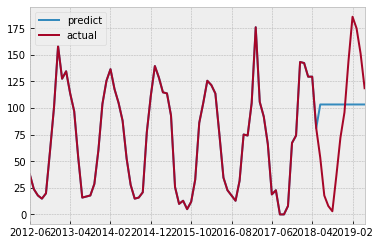

In [ ]:
pd.concat([X_sample, y_pred]).plot()
pd.concat([X_sample, y_sample]).plot()
plt.legend(['predict', 'actual'])
plt.show()

In [ ]:
submission = model_4(X_test)
submission.head()

,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05
id,,,,,,,,,,,,
78587,54.592393,54.592393,54.592393,54.592393,54.592393,54.592393,54.592393,54.592393,54.592393,54.592393,54.592393,54.592393
78588,51.490254,51.490254,51.490254,51.490254,51.490254,51.490254,51.490254,51.490254,51.490254,51.490254,51.490254,51.490254
78589,43.035421,43.035421,43.035421,43.035421,43.035421,43.035421,43.035421,43.035421,43.035421,43.035421,43.035421,43.035421
78590,46.462803,46.462803,46.462803,46.462803,46.462803,46.462803,46.462803,46.462803,46.462803,46.462803,46.462803,46.462803
78591,51.995239,51.995239,51.995239,51.995239,51.995239,51.995239,51.995239,51.995239,51.995239,51.995239,51.995239,51.995239


In [ ]:
submission.to_csv('submissions/submission_NAIVE.csv')

### 5. Holt's Linear Trend Method

In [ ]:
def model_5(df):
    def HOLT(row):
        model = Holt(row, damped = True)
        model_fit = model.fit(smoothing_level = .3, smoothing_slope = .1)
        return model_fit.forecast(12)

    pred = map(HOLT, df.values)
    result = pd.DataFrame(
        data = pred,
        columns = sample_submission.columns,
        index = df.index
    )
    return result

In [ ]:
X_sample, y_sample = X_train.iloc[0], y_train.iloc[0]
y_pred = model_5(X_train).iloc[0]

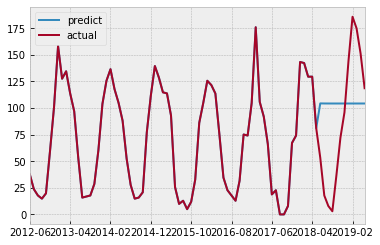

In [ ]:
pd.concat([X_sample, y_pred]).plot()
pd.concat([X_sample, y_sample]).plot()
plt.legend(['predict', 'actual'])
plt.show()

In [ ]:
submission = model_5(X_test)
submission.head()

,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05
id,,,,,,,,,,,,
78587,54.749395,54.664998,54.640112,54.632775,54.630611,54.629973,54.629785,54.629729,54.629713,54.629708,54.629707,54.629706
78588,51.583926,51.514127,51.496471,51.492005,51.490875,51.490589,51.490517,51.490499,51.490494,51.490493,51.490493,51.490493
78589,43.004234,42.902033,42.874078,42.866431,42.864339,42.863767,42.863611,42.863568,42.863556,42.863553,42.863552,42.863552
78590,46.921567,46.897770,46.889255,46.886208,46.885118,46.884727,46.884588,46.884538,46.884520,46.884514,46.884511,46.884510
78591,52.074848,51.993812,51.973389,51.968242,51.966944,51.966617,51.966535,51.966514,51.966509,51.966508,51.966507,51.966507


In [ ]:
submission.to_csv('submissions/submission_NAIVE_5.csv')

### 6. Holt-Winters Method

- 모델이 탄생한 목적에 맞게 계절성을 가진 우리의 데이터를 잘 예측합니다.

In [ ]:
def model_6(df):
    def HWM(row):
        model = ExponentialSmoothing(row, trend = None, seasonal = 'add', seasonal_periods = 12)
        model_fit = model.fit(smoothing_level = .2)
        return model_fit.forecast(12)

    pred = map(HWM, df.values)
    result = pd.DataFrame(
        data = pred,
        columns = sample_submission.columns,
        index = df.index
    )
    return result

In [ ]:
X_sample, y_sample = X_train.iloc[0], y_train.iloc[0]
y_pred = model_6(X_train.iloc[0: 1]).iloc[0]

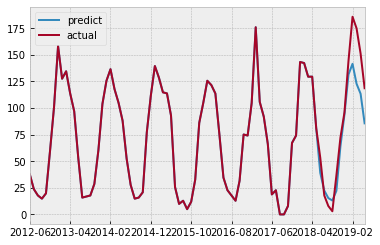

In [ ]:
pd.concat([X_sample, y_pred]).plot()
pd.concat([X_sample, y_sample]).plot()
plt.legend(['predict', 'actual'])
plt.show()

In [ ]:
submission = model_6(X_test)
submission.head()

,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05
id,,,,,,,,,,,,
78587,20.969710,18.889169,17.466976,15.881381,18.580883,29.845296,65.997966,80.234099,84.083553,75.406362,57.005804,35.318620
78588,17.083512,7.519136,3.563088,-0.061306,5.540973,16.418261,37.352202,79.704504,77.558424,72.114040,65.849623,43.931909
78589,11.277316,11.830035,9.586073,9.977126,12.671532,21.469221,55.973604,78.617985,80.650700,67.360081,44.516118,17.220504
78590,8.206761,2.954768,2.651181,0.695847,5.338863,15.253549,46.591587,70.346296,72.024344,74.842361,50.310396,27.925111
78591,24.607676,22.424508,19.252993,21.026546,22.960106,31.325275,58.642037,90.417131,86.253888,75.490783,43.642563,30.262612


In [ ]:
submission.to_csv('submissions/submission_NAIVE_6.csv')